1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

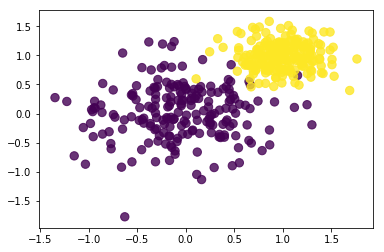

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

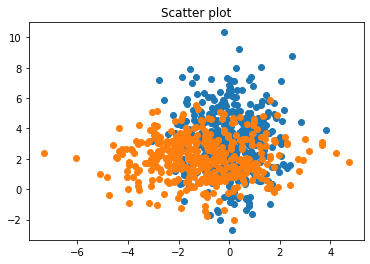

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def data_visualization(mean_one, mean_two, cov_one, cov_two, size):
    data1 = np.random.multivariate_normal(mean_one, cov_one, size)
    data2 = np.random.multivariate_normal(mean_two, cov_two, size)
    fig, ax = plt.subplots()
    plt.scatter(data1[:,0],data1[:,1])
    plt.scatter(data2[:,0],data2[:,1])
    plt.title('Scatter plot')

    
mean_one = np.array([0,3])
mean_two = np.array([-1, 2])
cov_one = np.array([[1,0],[0,4]])
cov_two = np.array([[3,0],[0,2]])

data_visualization(mean_one, mean_two, cov_one, cov_two, 400)    

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

Good binning



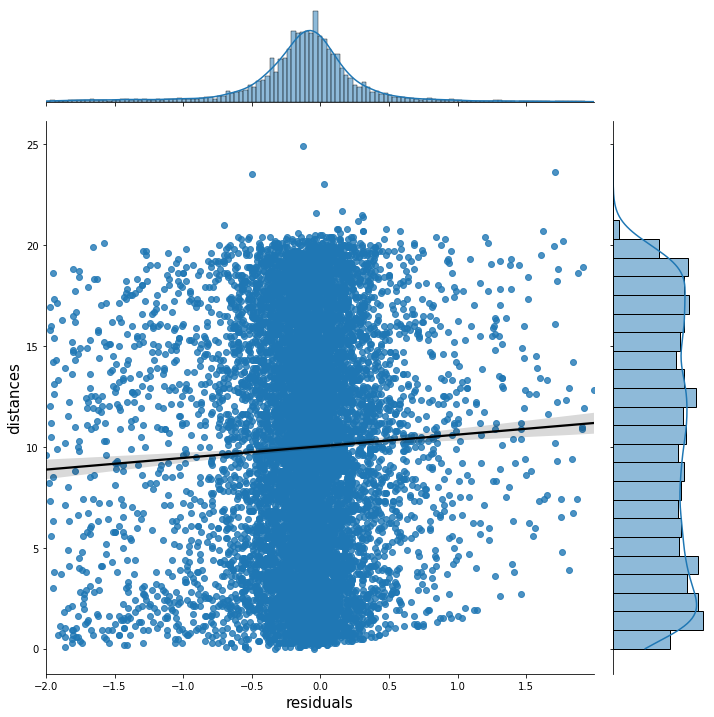

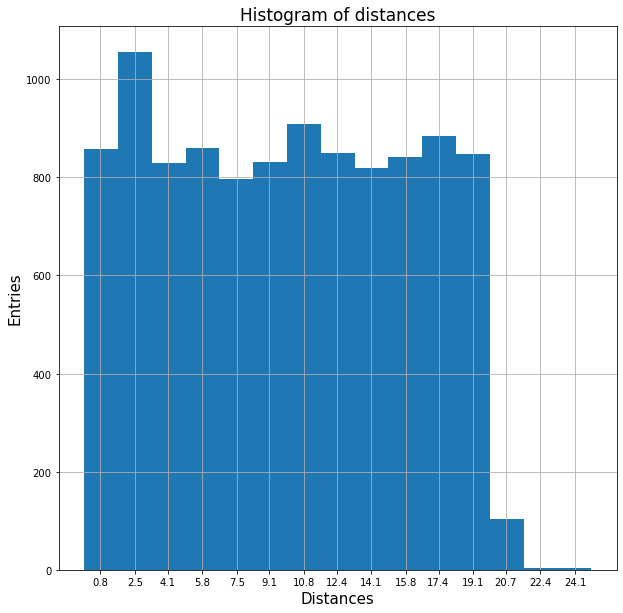

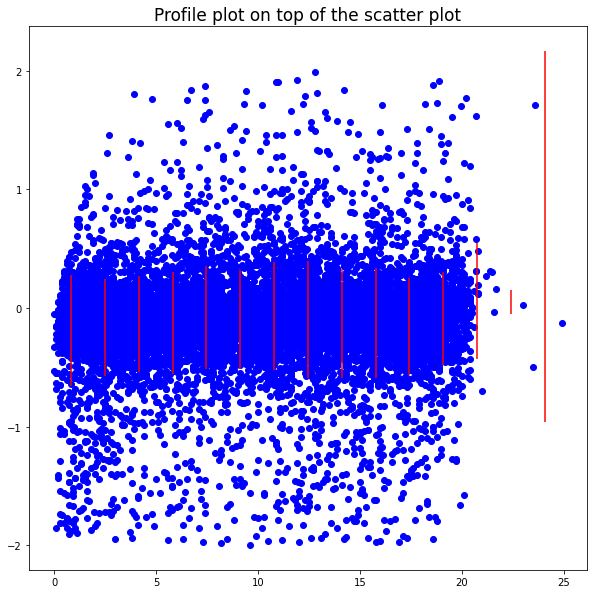

In [3]:
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
import seaborn as sns

filename = "data/residuals_261.pkl"
arr = np.load(filename, allow_pickle=True).item()
df = pd.DataFrame(arr)

filtered_df = df[abs(df['residuals']) < 2]

graph = sns.jointplot(data=filtered_df, x='residuals', y='distances', kind='reg', 
                      joint_kws={'line_kws':{'color':'black'}}, height=10)

graph.set_axis_labels('residuals', 'distances', fontsize=15)

#The correlation between the two variables is low. This is visible by looking at the regression line, almost flat.

fig, ax = plt.subplots(figsize=(10,10))

num_bins = 15
h, bins, _ = ax.hist(filtered_df['distances'], bins=num_bins, histtype='bar') # create and plot the histogram

# This part of the code was used to find a good value for num_bins
# It just checks the rule of thumb that we introduced during the lesson, about the Poisson uncertainty
# Since the uncertainty should be small with respect to n_i, I decided that small means lower that n_i
# minus the uncertainty itself, because I think that having uncertainty < n_i is enough to say that the
# uncertainty is small with respect to n_i
#----------------------------------------------------------------------------------------------------------
c = 0
for i in range(len(h)):
    n_i = h[i]
    uncertainty = 1/(n_i**0.5)
    if(uncertainty < n_i - uncertainty):
        c += 1

if(c == len(h)):
    print("Good binning\n")
else:
    print("Bad binning\n")
#----------------------------------------------------------------------------------------------------------        

x = 0.5*(bins[1:] + bins[:-1])
y = np.zeros(len(x))
err_y = np.zeros(len(x))

ax.set_xlabel('Distances', fontsize = 15)
ax.set_ylabel('Entries', fontsize = 15)
ax.set_title('Histogram of distances', fontsize = 17)
ax.set_xticks(np.round(x,1))
ax.grid('x')

#new column with a copy of the dataframe
df_copy = filtered_df.copy()
df_copy['bins'] = np.digitize(filtered_df.loc[:, 'distances'], bins=bins)

y = df_copy.groupby('bins')['residuals'].mean()
err_y = df_copy.groupby('bins')['residuals'].std()

# they must have the same length
y = y[:-1]
err_y = err_y[:-1]

#new figure
plt.subplots(figsize = (10,10))
plt.scatter(filtered_df['distances'], filtered_df['residuals'], c = 'blue')
plt.errorbar(x, y, yerr = err_y, color = 'red', ls = 'none')
plt.title('Profile plot on top of the scatter plot', fontsize = 17)
plt.show()

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


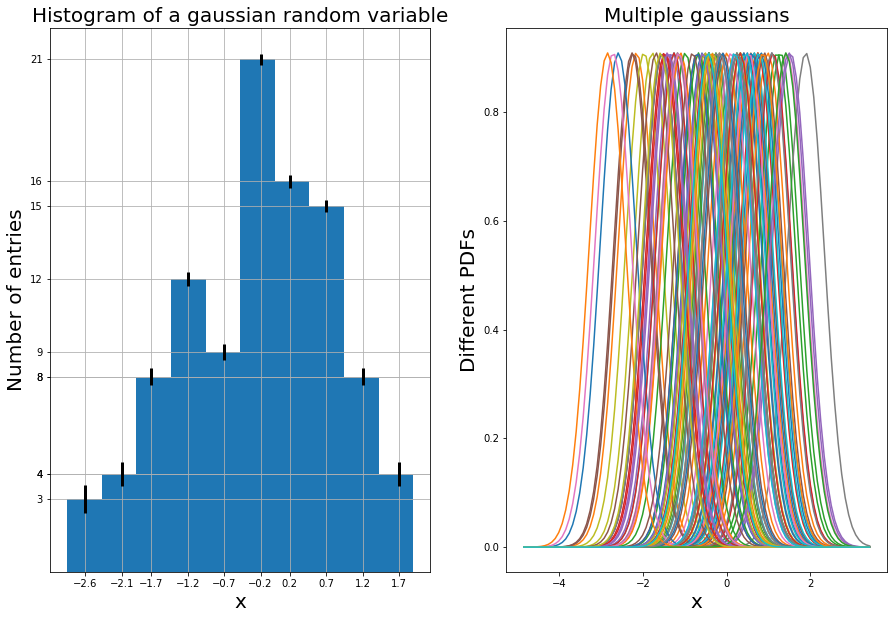

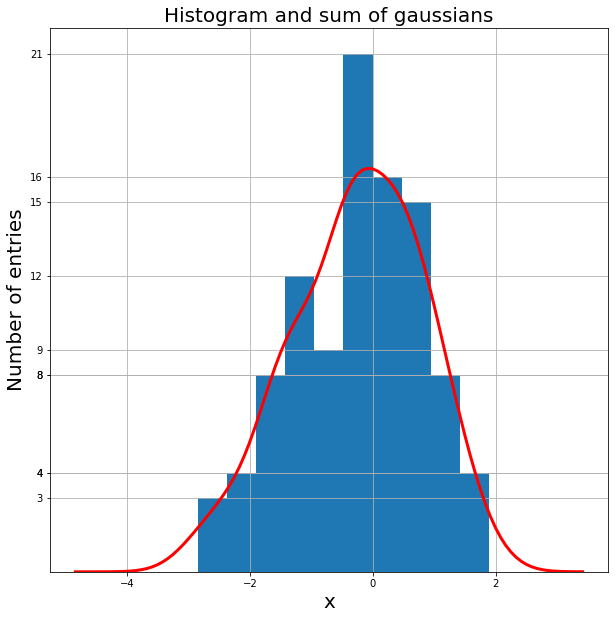

In [4]:
import numpy as np
from scipy import stats
from scipy import integrate

N = 100
mean, std = 0, 1
x = np.random.normal(mean, std, N)

# 1st figure ---------------------------------------------------------------------------------------------

fig, axes = plt.subplots(1,2, figsize=(15,10))

num_bins = 10   #computed using the same procedure as before

h, bins, _ = axes[0].hist(x, bins = num_bins)

centers = (bins[1:] + bins[:-1])*0.5
centers_rounded = np.round(centers,1)   #only one decimal digit, for a better visualization
axes[0].set_ylabel('Number of entries', fontsize = 20)
axes[0].set_xlabel('x', fontsize = 20)
axes[0].set_yticks(h)
axes[0].set_xticks(centers_rounded)
axes[0].grid()
axes[0].set_title('Histogram of a gaussian random variable', fontsize = 20)

#computing uncertainties
uncertainties = np.zeros(num_bins)
for i in range(len(uncertainties)):
    if(h[i] != 0):
        u = 1/np.sqrt(h[i])
    else:
        u = 0
    uncertainties[i] = u
axes[0].errorbar(centers_rounded, h, yerr = uncertainties, ls='none', linewidth=3, c='black')

# 2nd figure ---------------------------------------------------------------------------------------------

axes[1].set_title("Multiple gaussians", fontsize = 20)
axes[1].set_ylabel("Different PDFs", fontsize = 20)
axes[1].set_xlabel("x", fontsize = 20)

std = 1.06 * x.std() * (x.size**-(1/5))
v = np.linspace(bins[0]-2, bins[num_bins-1]+2, N)

pdfs = []
for i in range(len(x)):
    mean = x[i]
    gauss = stats.norm.pdf(v, mean, std)
    pdfs.append(gauss)
    axes[1].plot(v, gauss)

pdf_sum = np.array(pdfs).sum(axis=0)

area_histogram = 0
for i in range(num_bins):
    area_bin = h[i]*(bins[i+1]-bins[i])
    area_histogram += area_bin

area_trapz = integrate.trapz(pdf_sum, v)
norm = (area_histogram/area_trapz)*pdf_sum

# 3rd figure --------------------------------------------------------------------------------------------------

newfig, newax = plt.subplots(figsize=(10,10))
newax.hist(x, bins = num_bins)
newax.set_title('Histogram and sum of gaussians', fontsize = 20)
newax.set_yticks(h)
newax.grid()
newax.plot(v, norm, c='red', linewidth = 3)
newax.set_ylabel('Number of entries', fontsize = 20)
newax.set_xlabel('x', fontsize = 20)
plt.show()